In [187]:
from imp import reload
import cProfile

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cca
import gp

reload(cca)
reload(gp)

<module 'gp' from '/home/davidclark/Projects/ComplexityComponentsAnalysis/gp.py'>

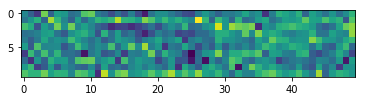

In [219]:
#Make Kernel
K = gp.gen_kernel("squared_exp", spatial_scale=0.5, temporal_scale=5.0)

#Generate 5,000 time-steps in total
T = 500
num_to_concat = 10

#Dimension of ambient space
N = 10

#Dimension of ambient space GP embedding
d = 3

#Noise covariance
noise_spectrum = np.ones(N) #3*np.exp(-np.arange(N)/(N/2))
noise_V = scipy.stats.ortho_group.rvs(N)
noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

#Generate data 
X, E = gp.embed_gp(T, N, d, K, noise_cov, num_to_concat=num_to_concat, return_embedding=True)
plt.imshow(X[:5*X.shape[1], :].T)
plt.show()

In [251]:
reload(cca)
T_pi = 5

cross_cov_mats_reg = cca.calc_cross_cov_mats(X, 2*T_pi, regularization="Abadir", reg_ops={"M":10, "S":400, "skip":T_pi})
cross_cov_mats_no_reg = cca.calc_cross_cov_mats(X, 2*T_pi, regularization=None)

pi_proj_reg_vals = np.zeros(N+1)
pi_proj_no_reg_vals = np.zeros(N+1)

for opt_dim in range(1, N+1):
    
    V_opt_reg = cca.run_cca(cross_cov_mats_reg, opt_dim, init="random")
    V_opt_no_reg = cca.run_cca(cross_cov_mats_no_reg, opt_dim, init="random")
    
    pi_proj_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=V_opt_reg)
    pi_proj_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=V_opt_no_reg)
    
    pi_proj_reg_vals[opt_dim] = pi_proj_reg
    pi_proj_no_reg_vals[opt_dim] = pi_proj_no_reg
    
    print(pi_proj_reg, pi_proj_no_reg)
    
    
    

0.6674405061074148 0.6831266140055822
1.3308112841156656 1.3324113041679724
1.9928961740909144 1.9542371999575545
2.0218768832741705 2.040551224195989
2.039425405539364 2.1240660940877603
2.0543750076602825 2.210306536031183
2.0641249957403227 2.3038527639600894
2.0728058546528865 2.3982834364666945
2.081262994429924 2.4893817725677416
2.085670877948952 2.5759425511598395


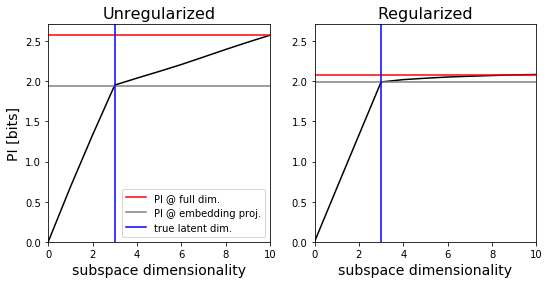

In [252]:
full_pi_reg = np.max(pi_proj_reg_vals)
embedding_pi_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_reg, proj=E)

full_pi_no_reg = np.max(pi_proj_no_reg_vals)
embedding_pi_no_reg = cca.calc_pi_from_cross_cov_mats(cross_cov_mats_no_reg, proj=E)

fig, axes = plt.subplots(1, 2, figsize=(8.75, 4))
ax1, ax2 = axes

ax1.plot(np.arange(N+1), pi_proj_no_reg_vals, c="black")
ax1.axhline(full_pi_no_reg, label="PI @ full dim.", c="red")
ax1.axhline(embedding_pi_no_reg, label="PI @ embedding proj.", c="gray")
ax1.axvline(d, label="true latent dim.", c="blue")

ax1.set_title("Unregularized", fontsize=16)
ax1.set_xlabel("subspace dimensionality", fontsize=14)
ax1.set_ylabel("PI [bits]", fontsize=14)

ax2.plot(np.arange(N+1), pi_proj_reg_vals, c="black")
ax2.axhline(full_pi_reg, label="PI @ full dim.", c="red")
ax2.axhline(embedding_pi_reg, label="PI @ embedding proj.", c="gray")
ax2.axvline(d, label="true latent dim.", c="blue")

ax2.set_title("Regularized", fontsize=16)
ax2.set_xlabel("subspace dimensionality", fontsize=14)
#ax2.set_ylabel("PI [bits]", fontsize=14)

ax1.legend()

ax1.set_xlim([0, N])
ax1.set_ylim([0, np.max(pi_proj_vals)*1.1])

ax2.set_xlim([0, N])
ax2.set_ylim([0, np.max(pi_proj_vals)*1.1])

plt.savefig("figs/cca_regularization.pdf", bbox_inches="tight")

plt.show()